In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
#read training and testing data set

train_df = pd.read_parquet('data/fhv_tripdata_2021-01.parquet')
test_df = pd.read_parquet('data/fhv_tripdata_2021-02.parquet')

train_df.shape, test_df.shape

((1154112, 7), (1037692, 7))

In [3]:
f'Q1. No of records in Jan fhv data: {train_df.shape[0]}'

'Q1. No of records in Jan fhv data: 1154112'

In [4]:
#exploring train data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1154112 entries, 0 to 1154111
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   dispatching_base_num    1154112 non-null  object        
 1   pickup_datetime         1154112 non-null  datetime64[ns]
 2   dropOff_datetime        1154112 non-null  datetime64[ns]
 3   PUlocationID            195845 non-null   float64       
 4   DOlocationID            991892 non-null   float64       
 5   SR_Flag                 0 non-null        object        
 6   Affiliated_base_number  1153227 non-null  object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 61.6+ MB


In [5]:
train_df['duration'] = train_df.dropOff_datetime - train_df.pickup_datetime
train_df.duration = train_df.duration.apply(lambda du: du.total_seconds()/60)

train_df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number,duration
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009,17.000000
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009,17.000000
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013,110.000000
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037,8.283333
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037,15.216667


In [6]:
train_df.describe() , f'Q2. Average duration in Jan 2021 FHV: {train_df.duration.mean()}'
#avg duration time : 19.16

(        PUlocationID   DOlocationID      duration
 count  195845.000000  991892.000000  1.154112e+06
 mean      139.859690     135.898030  1.916722e+01
 std        74.991382      80.474902  3.986922e+02
 min         1.000000       1.000000  1.666667e-02
 25%        75.000000      67.000000  7.766667e+00
 50%       143.000000     132.000000  1.340000e+01
 75%       206.000000     213.000000  2.228333e+01
 max       265.000000     265.000000  4.233710e+05,
 'Q2. Average duration in Jan 2021 FHV: 19.167224093791006')

/usr/local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

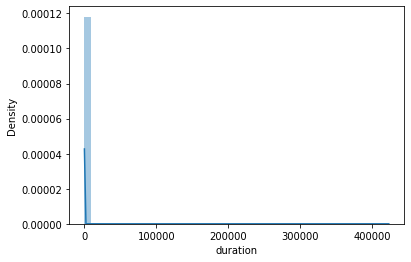

In [7]:
sns.distplot(train_df.duration)

In [8]:

#describing duartion
train_df.duration.describe(percentiles=[0.98,0.99])


count    1.154112e+06
mean     1.916722e+01
std      3.986922e+02
min      1.666667e-02
50%      1.340000e+01
98%      6.613333e+01
99%      9.030000e+01
max      4.233710e+05
Name: duration, dtype: float64

In [9]:
# distribution of mean
((train_df.duration >= 1) & (train_df.duration <=60)).mean() , ((train_df.duration >= 1) & (train_df.duration <=75)).mean() , \
    ((train_df.duration >= 1) & (train_df.duration <=100)).mean()

(0.9616276409915155, 0.9722236663339433, 0.9788287445239283)

In [10]:
total_records = train_df.shape[0]
total_records

1154112

In [11]:
# filtering training df
train_df = train_df[(train_df.duration >= 1) & (train_df.duration <=60)]

filtered_records = train_df.shape[0]
filtered_records

1109826

In [13]:
#number outliner records dropped
f'number outliner records dropped: {total_records - filtered_records}' 

'number outliner records dropped: 44286'

In [14]:
#null handling
train_df.isnull().sum()

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID               927008
DOlocationID               147907
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64

In [15]:
#percentage of missing values in pickup location
total_PUlocationID = train_df.PUlocationID.size
null_PUlocationID = train_df.PUlocationID.isnull().sum()
percent_missing = (null_PUlocationID/total_PUlocationID)*100
f'Q3. fractions of missing values for the pickup location ID: {percent_missing} %'

'Q3. fractions of missing values for the pickup location ID: 83.52732770722618 %'

In [16]:
#replacing NaN of feature columns with -1
train_df['PUlocationID'] = train_df['PUlocationID'].fillna(-1)
train_df['DOlocationID'] = train_df['DOlocationID'].fillna(-1)
train_df.isnull().sum()

dispatching_base_num            0
pickup_datetime                 0
dropOff_datetime                0
PUlocationID                    0
DOlocationID                    0
SR_Flag                   1109826
Affiliated_base_number        773
duration                        0
dtype: int64

In [17]:
# feature selection
train_df['PUlocationID'] = train_df['PUlocationID'].astype(str)
train_df['DOlocationID'] = train_df['DOlocationID'].astype(str)

train_df['PU_DO'] = train_df.PUlocationID + '_' + train_df.DOlocationID

categorical_feature = ['PUlocationID','DOlocationID']
label = 'duration'

In [18]:
# one hot encoding of training data set
train_dict = train_df[categorical_feature].to_dict(orient='records')

dv = DictVectorizer()

X_train = dv.fit_transform(train_dict)
y_train = train_df[label].values


In [19]:
#exploring the dict vectorized features
len(dv.feature_names_) , X_train.shape

(525, (1109826, 525))

In [20]:
X_train.shape, y_train.shape

((1109826, 525), (1109826,))

In [21]:
f'Q4. dimensionality of feature matrix: {X_train.shape[-1]}'

'Q4. dimensionality of feature matrix: 525'

In [22]:
#linear regression
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_train)



In [23]:
#rmse for training data
RMSE_train = mean_squared_error(y_train,y_pred,squared=False)
f'RMSE of the model on the training data: {RMSE_train}'

'RMSE of the model on the training data: 10.528519463473573'

In [24]:
#preparing test data
test_df['duration'] = test_df.dropOff_datetime - test_df.pickup_datetime
test_df.duration = test_df.duration.apply(lambda du: du.total_seconds()/60)

test_df = test_df[(test_df.duration >= 1) & (test_df.duration <=60)]



test_df.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 990113 entries, 1 to 1037691
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   dispatching_base_num    990113 non-null  object        
 1   pickup_datetime         990113 non-null  datetime64[ns]
 2   dropOff_datetime        990113 non-null  datetime64[ns]
 3   PUlocationID            141452 non-null  float64       
 4   DOlocationID            855353 non-null  float64       
 5   SR_Flag                 0 non-null       object        
 6   Affiliated_base_number  990113 non-null  object        
 7   duration                990113 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(3)
memory usage: 68.0+ MB


In [25]:
test_df.isnull().sum()

dispatching_base_num           0
pickup_datetime                0
dropOff_datetime               0
PUlocationID              848661
DOlocationID              134760
SR_Flag                   990113
Affiliated_base_number         0
duration                       0
dtype: int64

In [26]:
#replacing NaN with 
test_df['PUlocationID'] = test_df.PUlocationID.fillna(-1)
test_df['DOlocationID'] = test_df.DOlocationID.fillna(-1)

test_df.isnull().sum()

dispatching_base_num           0
pickup_datetime                0
dropOff_datetime               0
PUlocationID                   0
DOlocationID                   0
SR_Flag                   990113
Affiliated_base_number         0
duration                       0
dtype: int64

In [27]:
#preparing X_test and y_test
test_df['PUlocationID'] = test_df.PUlocationID.astype(str)
test_df['DOlocationID'] = test_df.DOlocationID.astype(str)

test_dict = test_df[['PUlocationID','DOlocationID']].to_dict(orient='records')

X_test = dv.transform(test_dict)
y_test = test_df.duration.values

X_test.shape , y_test.shape

((990113, 525), (990113,))

In [28]:
#evaluation of the same model with validation data set

y_pred_val = lr.predict(X_test)
f'Q6. RMSE on validation: {mean_squared_error(y_test,y_pred_val,squared=False)}'


'Q6. RMSE on validation: 11.014288298130957'